<a href="https://colab.research.google.com/github/aaronstone1699/CNN-SVM_brain_tumor/blob/main/brain_tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import os
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import accuracy_score
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
from tensorflow import keras
import numpy as np
import cv2
import os
import random
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D,Activation
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping
from tensorflow.keras.optimizers import Adam
import datetime
import time
import math as m
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.applications import ResNet50 as rn50

Found GPU at: /device:GPU:0


In [10]:
!unzip brain_tumor.zip

Archive:  brain_tumor.zip
  inflating: Testing/glioma_tumor/image(1).jpg  
  inflating: Testing/glioma_tumor/image(10).jpg  
  inflating: Testing/glioma_tumor/image(100).jpg  
  inflating: Testing/glioma_tumor/image(11).jpg  
  inflating: Testing/glioma_tumor/image(12).jpg  
  inflating: Testing/glioma_tumor/image(13).jpg  
  inflating: Testing/glioma_tumor/image(14).jpg  
  inflating: Testing/glioma_tumor/image(15).jpg  
  inflating: Testing/glioma_tumor/image(16).jpg  
  inflating: Testing/glioma_tumor/image(17).jpg  
  inflating: Testing/glioma_tumor/image(18).jpg  
  inflating: Testing/glioma_tumor/image(19).jpg  
  inflating: Testing/glioma_tumor/image(2).jpg  
  inflating: Testing/glioma_tumor/image(20).jpg  
  inflating: Testing/glioma_tumor/image(21).jpg  
  inflating: Testing/glioma_tumor/image(22).jpg  
  inflating: Testing/glioma_tumor/image(23).jpg  
  inflating: Testing/glioma_tumor/image(24).jpg  
  inflating: Testing/glioma_tumor/image(25).jpg  
  inflating: Testing/glio

In [11]:
#dataset preparartion class to make it easier to load the data
class DataSet:
    
    def __init__(me,location,categories,resize=True,
                 lheight=500,lwidth=500,grayscale=True,shuffled=False,
                 apply=None,count=1000,multiclass=False,enhance=False):
        me.categories=categories
        me.datadir=location
        me.lheight=lheight
        me.lwidth=lwidth
        me.grayscale=grayscale
        me.shuffled=shuffled
        me.multiclass=multiclass
        me.apply=apply
        me.count=count
        me.enhance=enhance
        me.dataset=me.create_traindata()
        if resize==True:
            me.dataset=me.resizeIt(me.dataset)

        
        
    
    def resizeIt(me,traindata_array):
        resized_traindata=[]
        resized_traindata_temp=[]
        for img in traindata_array[0]:
            
            new_image_array=cv2.resize(img,(me.lheight,me.lwidth))
            resized_traindata_temp.append(np.array(new_image_array))
        array=[np.array(resized_traindata_temp),np.array(traindata_array[1])]
        return(array)



    def create_traindata(me):
        traindata=[]
        cart = 0
        for cats in me.categories:
            n=0
            path=os.path.join(me.datadir,cats)
            class_num=me.categories.index(cats)
            tot = len(os.listdir(path))
            cart = cart + tot
            for img in os.listdir(path):
                print("\r",end = " ")
                print("{0} / {1}, {2:.2f}% Completed from {3}".format(len(traindata),cart,n/tot*100,cats),end = " ")
                if(me.grayscale==True and me.enhance==True):
                    y=cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)

                    y=cv2.resize(y,(512,512))


                    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(5,5))
                    img_array = clahe.apply(y)

                    img_array = cv2.GaussianBlur(y,(3,3),1)


                    n=n+1
                    #print(str(n)+" images loaded successfully",end='')
                    if n>=me.count:
                      break
                
                elif(me.enhance==True):
                    #print(os.path.join(path,str(img)))
                    img_array=cv2.imread(os.path.join(path,img))
                    img_yuv_1 = cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB)
                    img_gray = cv2.cvtColor(img_array,cv2.COLOR_BGR2GRAY)
                    _,thresh = cv2.threshold(img_gray,16,255,cv2.THRESH_BINARY)
                    img_yuv = cv2.cvtColor(img_yuv_1,cv2.COLOR_RGB2YUV)
                    y,u,v = cv2.split(img_yuv)
                    crow = cv2.bitwise_xor(y,thresh)
                    _,thresh = cv2.threshold(crow,16,255,cv2.THRESH_BINARY)
                    contours,hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
                    cnt = contours[-1]
                    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8,8))
                    y = clahe.apply(y)

                    y = cv2.GaussianBlur(y,(3,3),0)

                    img_array_1 = cv2.merge((y,u,v))
                    img_array = cv2.cvtColor(img_array_1,cv2.COLOR_YUV2RGB)

                    x,y,w,h = cv2.boundingRect(cnt)

                    img_array = img_array[y:y+h,x:x+w]

                    
                    n=n+1
                    #print(str(n)+" images loaded successfully",end='')
                    if n>=me.count:
                      break
                else:
                    img_array=cv2.imread(os.path.join(path,img))

                    n=n+1
                    #print(str(n)+" images loaded successfully",end='')
                    if n>=me.count:
                      break
                if(me.multiclass==False):
                    traindata.append([img_array,class_num])

                else:
                    cl = me.classes(class_num=class_num,classes=len(me.categories))
                    traindata.append([img_array,cl])
                    #traindata.append([cv2.flip(img_array,0),cl])
                    traindata.append([cv2.flip(img_array,1),cl])
                    #traindata.append([cv2.flip(img_array,-1),cl])
                
            print()
            
        if(me.shuffled==True):
          random.shuffle(traindata)
          print("shuffled")
        traindata_img=[]
        traindata_lab=[]
        for sets in traindata:
            traindata_img.append(sets[0])
            traindata_lab.append(sets[1])
        traindata=[traindata_img,traindata_lab]
        return(traindata)

    def classes(me,class_num,classes):
        array = [0 for i in range(classes)]
        array[class_num]=1
        return(array)
    



In [12]:
#path of the folder containing subfolder with images
path="/content/Training"

#names of the subfolders
class_names=os.listdir(path)

#function to load the dataset into the variable dataset
dataset=DataSet(path,categories=class_names,lheight=224,
                lwidth=224,grayscale=True,apply=None,
                count=800,shuffled=True,multiclass=True,enhance=True)
#flip takes 2 parameters,first is true or false,
#second is an array of flipcodes as mentioned below :
#flip[1] = 0: flip vertically
#flip[1] > 0: flip horizontally
#flip[1] < 0: flip vertically and horizontally


#data contains the numpy image array
dataset=dataset.dataset


#this returns a shuffled numpy array with the format [[images][labels]] to data

 1598 / 822, 97.20% Completed from meningioma_tumor 
 3196 / 1648, 96.73% Completed from glioma_tumor 
 3984 / 2043, 99.75% Completed from no_tumor 
 5584 / 2870, 96.61% Completed from pituitary_tumor 
shuffled


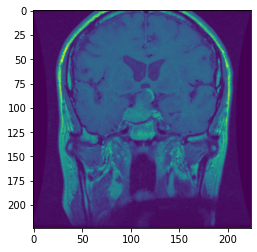

In [13]:
plt.imshow(dataset[0][50])

In [26]:

tumor_Classifier=Sequential()
tumor_Classifier.add(Convolution2D(16,(5,5),input_shape=(224,224,1),activation='relu'))
tumor_Classifier.add(MaxPooling2D(pool_size=(2,2)))
tumor_Classifier.add(Convolution2D(32,(5,5),activation='relu'))
tumor_Classifier.add(MaxPooling2D(pool_size=(2,2)))
tumor_Classifier.add(Convolution2D(64,(5,5),activation='relu'))
tumor_Classifier.add(MaxPooling2D(pool_size=(2,2)))
tumor_Classifier.add(Convolution2D(128,(5,5),activation='relu'))
tumor_Classifier.add(MaxPooling2D(pool_size=(2,2)))
tumor_Classifier.add(Convolution2D(256,(5,5),activation='relu'))
tumor_Classifier.add(MaxPooling2D(pool_size=(2,2)))
tumor_Classifier.add(Flatten())
tumor_Classifier.add(Dense(64,activation='relu'))
tumor_Classifier.add(Dense(32,activation='relu'))
tumor_Classifier.add(Dropout(0.5))
tumor_Classifier.add(Dense(16,activation='relu'))
tumor_Classifier.add(Dense(4, kernel_regularizer='l2',activation='linear'))
tumor_Classifier.compile(loss='categorical_hinge',
              optimizer='adam',
              metrics=['accuracy'])

print(tumor_Classifier.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 220, 220, 16)      416       
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 110, 110, 16)      0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 106, 106, 32)      12832     
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 53, 53, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 49, 49, 64)        51264     
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 20, 20, 128)      

In [27]:
history = tumor_Classifier.fit( dataset[0].reshape(-1,224,224,1),dataset[1],batch_size =201,epochs=100,validation_split=0.1)

Train on 5025 samples, validate on 559 samples
Epoch 1/100
5025/5025 [==============================] - ETA: 0s - loss: 1.7027 - acc: 0.2882

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


5025/5025 [==============================] - 6s 1ms/sample - loss: 1.7027 - acc: 0.2882 - val_loss: 1.0595 - val_acc: 0.4401
Epoch 2/100
5025/5025 [==============================] - 5s 901us/sample - loss: 1.0582 - acc: 0.4113 - val_loss: 1.0565 - val_acc: 0.4848
Epoch 3/100
5025/5025 [==============================] - 5s 905us/sample - loss: 1.0555 - acc: 0.4631 - val_loss: 1.0515 - val_acc: 0.5993
Epoch 4/100
5025/5025 [==============================] - 5s 907us/sample - loss: 1.0460 - acc: 0.4905 - val_loss: 1.0058 - val_acc: 0.3989
Epoch 5/100
5025/5025 [==============================] - 5s 908us/sample - loss: 1.0213 - acc: 0.4161 - val_loss: 1.0564 - val_acc: 0.4186
Epoch 6/100
5025/5025 [==============================] - 5s 906us/sample - loss: 1.0119 - acc: 0.3765 - val_loss: 0.8843 - val_acc: 0.3095
Epoch 7/100
5025/5025 [==============================] - 5s 910us/sample - loss: 0.9108 - acc: 0.4760 - val_loss: 0.8699 - val_acc: 0.5385
Epoch 8/100
5025/5025 [==================

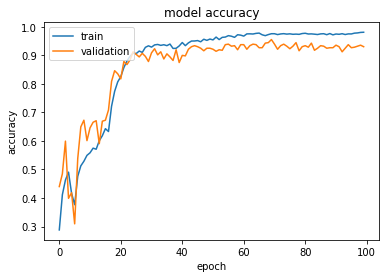

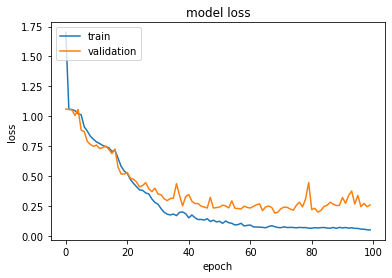

In [29]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [37]:
tumor_Classifier.predict(dataset[0][4068].reshape(-1,224,224,1))

array([[ 1.0014737e+00, -3.9732456e-04, -8.7608472e-03, -1.2325697e-02]],
      dtype=float32)

In [36]:
dataset[1][4068]

array([1, 0, 0, 0])

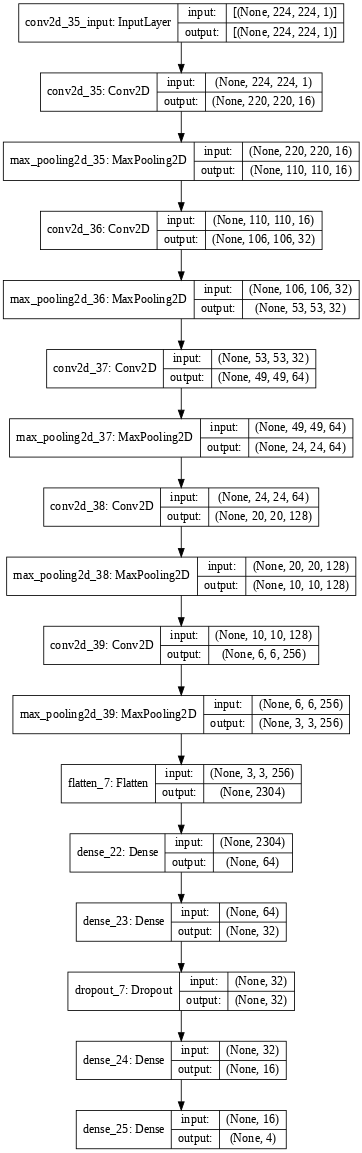

In [38]:
plot_model(tumor_Classifier,'model.png',True,False,True,'TB',True,60)

In [40]:
tumor_Classifier.save('CNN+SVM(93).h5')

In [41]:
#path of the folder containing subfolder with images
path="/content/Testing"

#names of the subfolders
class_names=os.listdir(path)

#function to load the dataset into the variable dataset
dataset=DataSet(path,categories=class_names,lheight=224,
                lwidth=224,grayscale=True,apply=None,
                count=800,shuffled=True,multiclass=True,enhance=True)
#flip takes 2 parameters,first is true or false,
#second is an array of flipcodes as mentioned below :
#flip[1] = 0: flip vertically
#flip[1] > 0: flip horizontally
#flip[1] < 0: flip vertically and horizontally


#data contains the numpy image array
dataset=dataset.dataset


#this returns a shuffled numpy array with the format [[images][labels]] to data

 228 / 115, 99.13% Completed from meningioma_tumor 
 428 / 215, 99.00% Completed from glioma_tumor 
 638 / 320, 99.05% Completed from no_tumor 
 786 / 394, 98.65% Completed from pituitary_tumor 
shuffled


In [67]:
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import recall_score as rec
from sklearn.metrics import precision_score as prec
from sklearn.metrics import f1_score as f1
from sklearn.metrics import confusion_matrix as cfm
from sklearn.metrics import classification_report as clrep
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

Text(-54.375, 0.5, 'Predicted label')

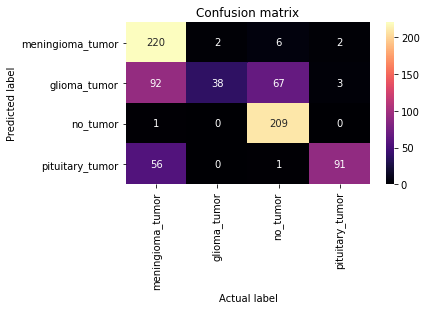

In [56]:
fig, ax = plt.subplots()
df_cm = pd.DataFrame(mat, index = [i for i in class_names],columns = [i for i in class_names])
sns.heatmap(df_cm, annot=True,cmap="magma",fmt='d')
ax.xaxis.set_label_position('bottom')
plt.tight_layout()
plt.title('Confusion matrix', y=1.4)
plt.xlabel('Actual label')
plt.ylabel('Predicted label')


In [71]:
print(clrep(labels,predicted,target_names = class_names))

                  precision    recall  f1-score   support

meningioma_tumor       0.60      0.96      0.73       230
    glioma_tumor       0.95      0.19      0.32       200
        no_tumor       0.74      1.00      0.85       210
 pituitary_tumor       0.95      0.61      0.75       148

        accuracy                           0.71       788
       macro avg       0.81      0.69      0.66       788
    weighted avg       0.79      0.71      0.66       788



In [53]:
predicted = np.argmax(tumor_Classifier.predict(dataset[0].reshape(-1,224,224,1)),axis = -1)

In [54]:
labels = np.argmax(dataset[1],axis = -1)

In [55]:
mat = cfm(labels,predicted)